In [1]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed

%matplotlib inline

In [2]:
class KBanditArmed:

    def __init__(self, k_arms=10, epsilon=0., prior_estimation=0., true_reward=0.):

        """
        :param k_arms: `int`
            number of arms
        :param epsilon: `float` [0,1]
            epsilon-greedy algorithm parameter. (probability of exploration)
        :param prior_estimation: `float` or `list`
            prior estimation for each action
        :param true_reward: `float` or `list`
            True reward for each arm.
        """
        self.k = k_arms
        self.arms = np.arange(self.k)
        self.time = 0
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.prior_estimation = prior_estimation

        self.q_true = None  # true value for each arm
        self.q_estimate = None  # the current estimate for the reward of each arm
        self.action_count = None # how many times each arm was used.
        self.best_action = None  # the best action amoung all the arms.

    def initialize(self):
        """
        Initialize the process

        :return: None
        """
        self.q_true = np.random.randn(self.k) + self.true_reward
        self.q_estimate = np.zeros(self.k) + self.prior_estimation
        self.action_count = np.zeros(self.k)
        self.best_action = np.argmax(self.q_true)


    def simulate(self, epochs=1000):
        """
        Simulate `epochs` times the K bandit arm.
        
        param: epochs
            number of epochs.
        
        return: np.array shape (epochs,2)
            array with the rewards received and if this action was the optimal action.
        """
        self.initialize()
        action_rewards_best_action = np.zeros((epochs,2))
        for t in range(epochs):
            action = self.get_action()
            reward = self.step(action)
            #action_rewards_best_action[t,0] = action
            action_rewards_best_action[t,0] = reward
            if action == self.best_action:
                action_rewards_best_action[t,1] = 1
        return action_rewards_best_action
    
    def get_action(self):
        """
        Return an action
        
        :return: 
            action
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.arms)

        q_best = np.max(self.q_estimate)
        return np.random.choice([action
                                 for action, q in enumerate(self.q_estimate)
                                 if q == q_best])

    def get_reward(self, action, mu=0, sigma=1):

        """

        Get reward from an action

        :param action:
            arm to get the true reward
        :param mu:
            bias to add to the reward. (it might not make sense)
        :param sigma:
            variance of the noise to add to the reward.
        :return: reward
        """
        return sigma * np.random.randn() + mu + self.q_true[action]


    def step(self, action):
        """
            take an action, update estimation for this action

        :param action:
            arm to get the true reward
        :return:
            reward
        """
        # generate the reward
        reward = self.get_reward(action)
        # update time
        self.time += 1
        #compute the average reward
        self.average_reward += (reward - self.average_reward) / self.time
        #update the action count.
        self.action_count[action] += 1
        # update the estimate for the given action.
        # TODO: add step size
        self.q_estimate[action] += 1.0 / self.action_count[action] * (reward - self.q_estimate[action])

        return reward

In [ ]:
n_jobs=4
verbose=0
epsilons=[0, 0.01, 0.1, 0.5]
runs=2000
epochs=1000
k_arms=10
def run(k_arms, runs, epochs, epsilons, n_jobs=4, verbose=1):
    
    results = {}
    for i, epsilon in enumerate(epsilons):
        print(f'{i}')
        list_of_runs = Parallel(n_jobs=n_jobs, verbose=verbose)(delayed(KBanditArmed(k_arms=k_arms, epsilon=epsilon,
                                                                                     prior_estimation=0., 
                                                                                     true_reward=0.).simulate)(epochs=epochs)
                                                                for _ in range(runs))
        #compute avg rewards
        results[epsilon] = np.array(list_of_runs)
    return results

results =  run(k_arms=k_arms, runs=runs, epochs=epochs, epsilons=epsilons, n_jobs=n_jobs, verbose=verbose)

0


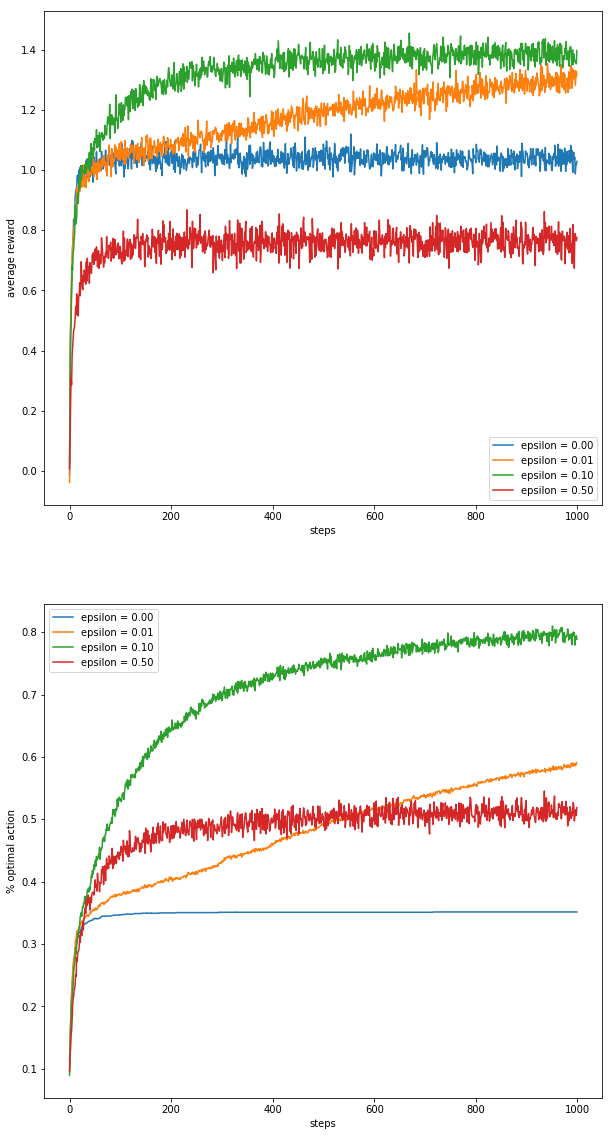

In [4]:
plt.figure(figsize=(10, 20))

plt.subplot(2, 1, 1)
for epsilon in epsilons:
    rewards = results.get(epsilon)[:,:,0].mean(axis=0)
    plt.plot(rewards, label='epsilon = %.02f' % (epsilon))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
for epsilon in epsilons:
    best_action_counts = results.get(epsilon)[:,:,1].mean(axis=0)
    plt.plot(best_action_counts, label='epsilon = %.02f' % (epsilon))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()
